Actual: [0.7631246036139581, 385.7196514281681, 0.027433890736511493, 1.2550561261723592]
Maximum-likelihood estimates: [7.63124604e-01 3.85719651e+02 2.74338907e-02 1.25505613e+00]
Percentage deviations: [1.80279363e-08 1.97504975e-10 1.59336699e-08 6.90370381e-09]
SD of fit: 1.1121681000409057e-11


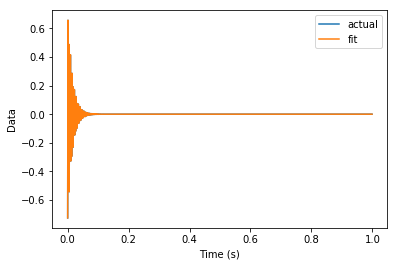

In [34]:
# aim of this notebook: get MLE working on some sort of exponential * sine combination. (no PSD just yet)

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
%matplotlib inline

A = np.random.uniform(low=0.1, high=1)
f = np.random.uniform(low=10.0, high=500.0)
k = np.random.uniform(low=1e-2, high=1e-1) # unitless
p = np.random.uniform(low=0, high=2*np.pi)
pars_actual = [A, f, k, p]
times = np.arange(0, 1, 0.001)

def damped_harmonic(pars_model):
    A, f, k, p = pars_model
    return A * np.exp(-k*2*np.pi*f*times) * np.sin(2*np.pi*f*times - p)

def log_likelihood(func, data):
    def get_ll(pars):
        pars_model, sd = pars[:-1], pars[-1]
        data_predicted = func(pars_model)
        LL = -np.sum(norm.logpdf(data, loc=data_predicted, scale=sd))
        return LL
    return get_ll

data_dh = damped_harmonic(pars_actual)

dh_ll = log_likelihood(damped_harmonic, data_dh)

pars_init = [1, 250, 0.07, np.pi/2, 0.1]
results = minimize(dh_ll, pars_init, method='Nelder-Mead')
pars_derived, sd = results.x[:-1], results.x[-1]
data_model = damped_harmonic(pars_derived)

if pars_derived[0] < 0:
    pars_derived[0] = -pars_derived[0]
    pars_derived[3] = (pars_derived[3] + np.pi) % (2 * np.pi)

print("Actual: " + str(pars_actual))
print("Maximum-likelihood estimates: " + str(pars_derived))
print("Percentage deviations: " + str(100 * np.abs((pars_actual - pars_derived)/(pars_actual))))
print("SD of fit: " + str(sd))
    
plt.plot(times, data_dh, label='actual')
plt.plot(times, data_model, label='fit')
plt.xlabel("Time (s)")
plt.ylabel("Data")
plt.legend()

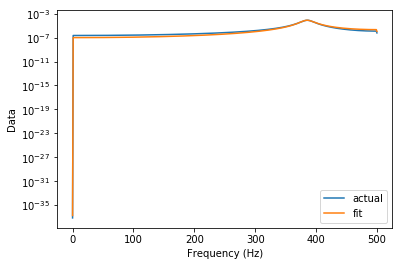

In [36]:
# okay...now for the same thing but with PSD fitting

from scipy.signal import periodogram

def psd(pars_model):
    return periodogram(damped_harmonic(pars_model), fs=1000)[1]

freqs = periodogram(damped_harmonic(pars_init[:-1]), fs=1000)[0]
psd_ll = log_likelihood(psd, psd([A, f, k, p]))
data_psd = psd([A, f, k, p])

results = minimize(psd_ll, pars_init, method='Nelder-Mead')
data_model = psd(results.x[:-1])
plt.semilogy(freqs, data_psd, label='actual')
plt.semilogy(freqs, data_model, label='fit')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Data")
plt.legend()

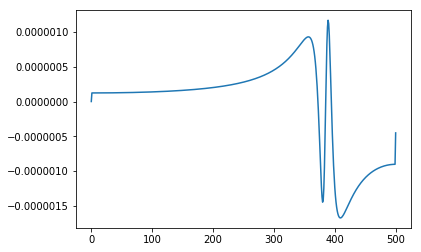

In [38]:
plt.plot(freqs, data_psd - data_model)

(1e-07, 2.943433726132877e-05)

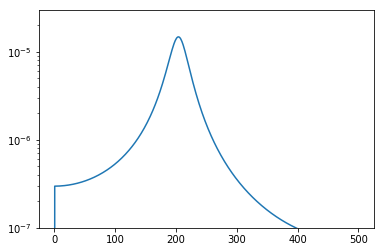

In [27]:
plt.semilogy(f, p)
plt.ylim((1e-7,max(p)*2))